# Image Recognition Covid Detection - Multi Classification[2]

## Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import itertools
import os
import torchvision
from torchsummary import summary
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from jcopdl.layers import linear_block, conv_block
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset and Dataloader

In [2]:
bs = 128
crop_size = 224 #jika image ukurannya berbeda-beda (crop&resize)

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15), # 15 derajat
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)), # cropnya jangan terlalu kecil, 80%-100% dari gambar baru di resize
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/Datasets-Covid-MultiClass/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/Datasets-Covid-MultiClass/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

## Exploratory Data Analysis (EDA)

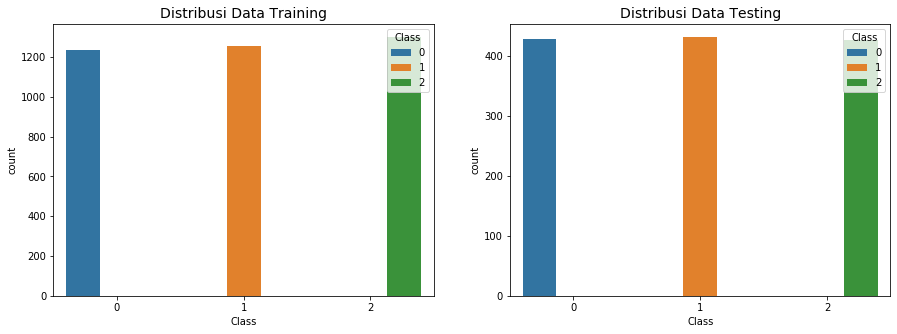

In [67]:
train = pd.DataFrame(train_set.samples,  columns=['Images', 'Class'])
test = pd.DataFrame(test_set.samples,  columns=['Images', 'Class'])

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.countplot('Class', data=train, hue='Class');
plt.title('Distribusi Data Training', fontsize=14);

plt.subplot(122)
sns.countplot('Class', data=test, hue='Class');
plt.title('Distribusi Data Testing', fontsize=14);

In [3]:
label2cat = train_set.classes
label2cat

['Covid-19', 'Normal', 'Pneumonia']

In [4]:
#cek
loader = iter(trainloader)
images, labels = next(loader)
images.shape

torch.Size([128, 1, 224, 224])

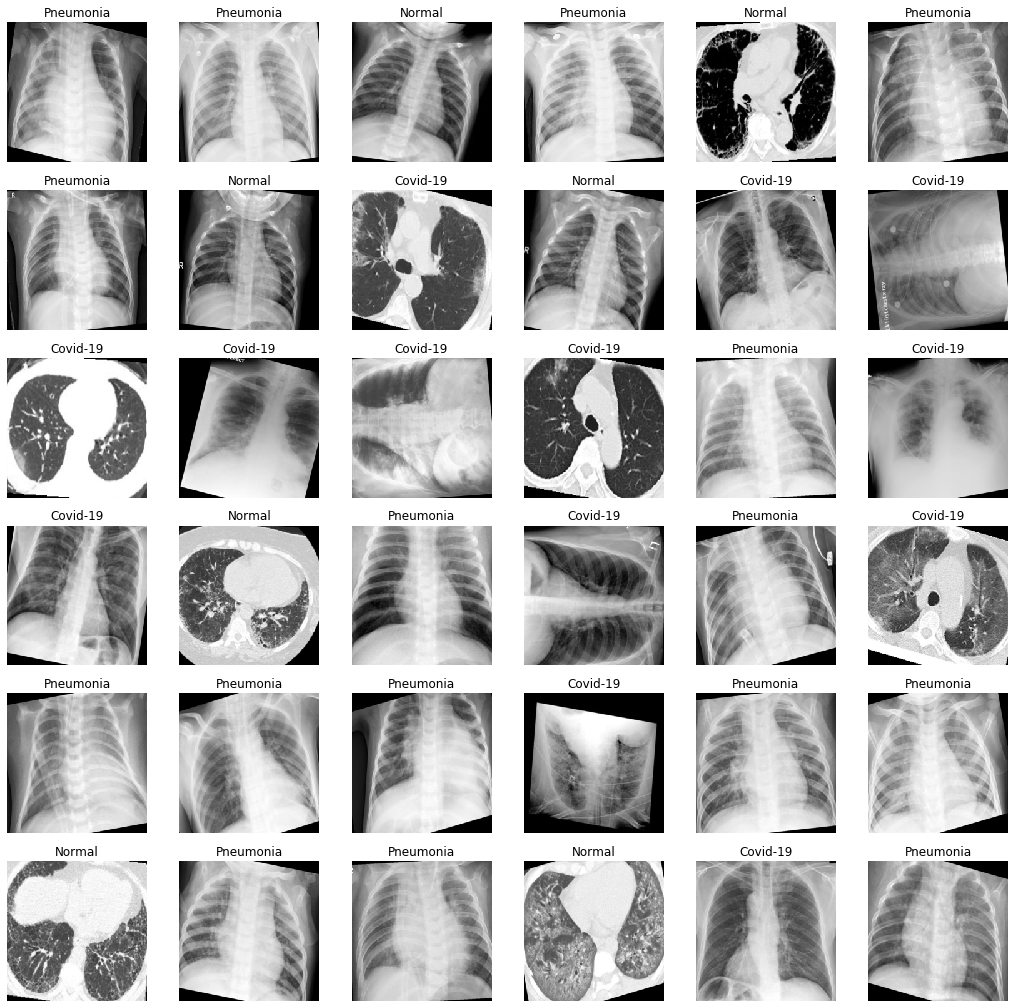

In [7]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
    label = label2cat[label.item()]
    ax.set_title(f"{label}")
    ax.axis('off');

## Arsitektur and Config

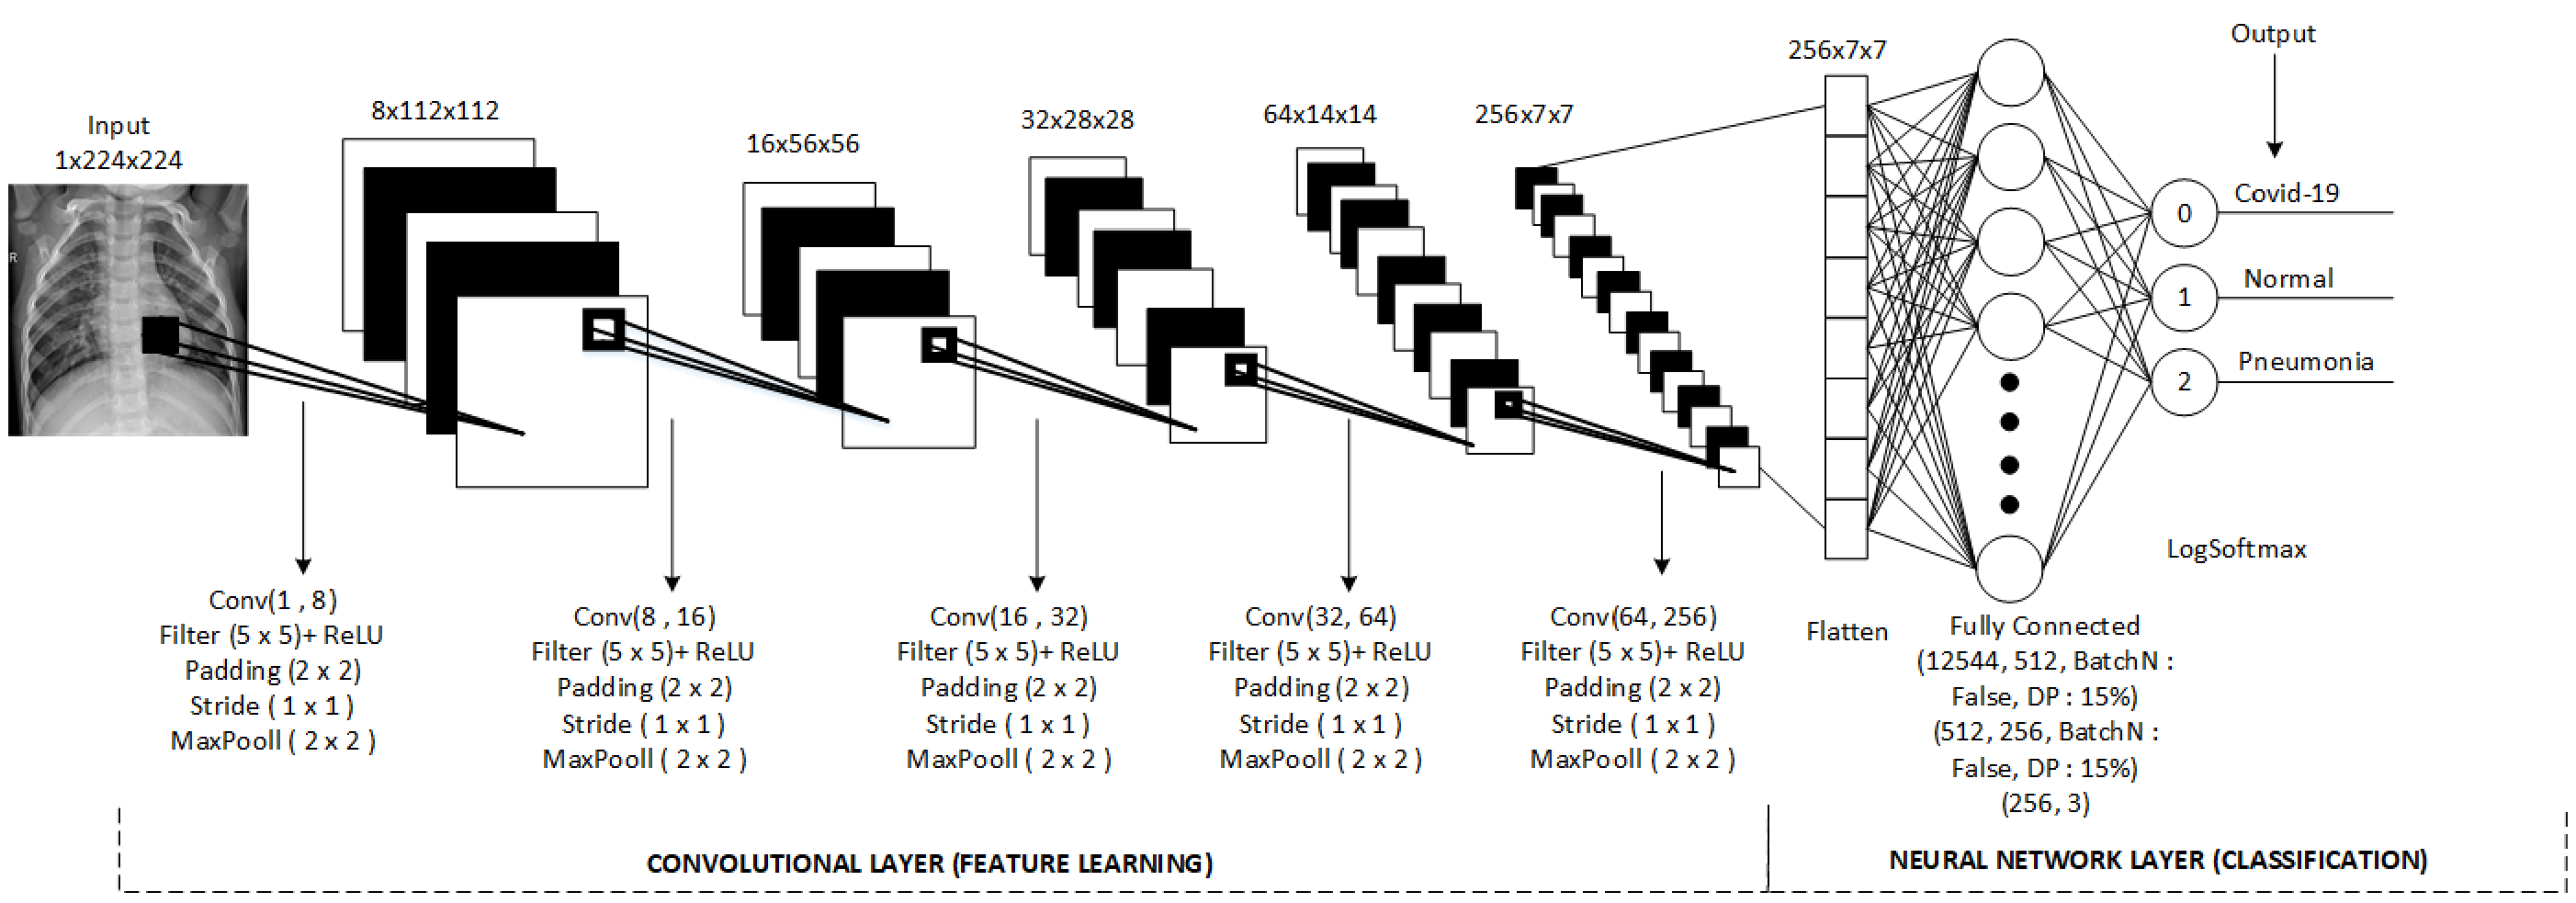

In [5]:
plt.figure(figsize=(50, 100))
arsitektur = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/arsitektur/arsitektur_2.png')
plt.imshow(arsitektur)
plt.axis('off');

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channel, conv1, conv2, conv3, conv4, kernel, pad, 
                 out_channel, in_size, n1, n2, dropout, out_size):
        super().__init__()
        
        self.convolutional = nn.Sequential(
            
            conv_block(in_channel, conv1, kernel=kernel, pad=pad),
            conv_block(conv1, conv2, kernel=kernel, pad=pad),
            conv_block(conv2, conv3, kernel=kernel, pad=pad),
            conv_block(conv3, conv4, kernel=kernel, pad=pad),
            conv_block(conv4, out_channel, kernel=kernel, pad=pad),
            nn.Flatten()
            
        )
        
        self.fc = nn.Sequential(
            
            linear_block(in_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, out_size, activation='lsoftmax')
        )
        
        
    def forward(self, x):
        x = self.convolutional(x)
        x = self.fc(x)
        return x
    
        

In [6]:
config = set_config ({
    
    "batch_size" : bs,
    "crop_size" : crop_size,
    "in_channel" : 1,
    "conv1" : 8,
    "conv2" : 16,
    "conv3" : 32,
    "conv4" : 64,
    "out_channel" : 256,
    "kernel" : 5,
    "pad" : 2,
    "in_size" : 256*7*7,
    "n1" : 512,
    "n2" : 256,
    "dropout" : 0.15,
    "out_size" : 3,
    "batch_norm" : "False",
    "author" : "Ridho Alhafizhi"
    
})

# torch.save(config, "model-CNN/model-covid/model-covid-multiclass/model-tunning-2/config.pth")

## Training Preparation >> MCOC

In [7]:
model = CNN(config.in_channel, config.conv1, config.conv2, config.conv3, config.conv4, config.kernel, config.pad, config.out_channel, config.in_size, config.n1, config.n2, config.dropout, config.out_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/model-covid/model-covid-multiclass/model-tunning-2/",early_stop_patience=10, plot_every=5)

In [20]:
parameter = summary(model, (1,224,224))
torch.save(parameter,"model/model-covid/model-covid-multiclass/model-tunning-2/model/total-params.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             208
              ReLU-2          [-1, 8, 224, 224]               0
              ReLU-3          [-1, 8, 224, 224]               0
              ReLU-4          [-1, 8, 224, 224]               0
              ReLU-5          [-1, 8, 224, 224]               0
              ReLU-6          [-1, 8, 224, 224]               0
              ReLU-7          [-1, 8, 224, 224]               0
              ReLU-8          [-1, 8, 224, 224]               0
         MaxPool2d-9          [-1, 8, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           3,216
             ReLU-11         [-1, 16, 112, 112]               0
             ReLU-12         [-1, 16, 112, 112]               0
             ReLU-13         [-1, 16, 112, 112]               0
             ReLU-14         [-1, 16, 1

## Training

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0003 | Test_cost  = 0.8796 | Train_score = 0.4559 | Test_score = 0.5109 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.8078 | Test_cost  = 0.8932 | Train_score = 0.6111 | Test_score = 0.5062 |
==> EarlyStop patience =  1 | Best test_score: 0.5109


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6518 | Test_cost  = 0.7917 | Train_score = 0.6950 | Test_score = 0.5436 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5080 | Test_cost  = 0.4692 | Train_score = 0.7749 | Test_score = 0.7850 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:57<00:00,  5.24s/it]



Epoch     5
Train_cost  = 0.4202 | Test_cost  = 0.4947 | Train_score = 0.8092 | Test_score = 0.7960 |


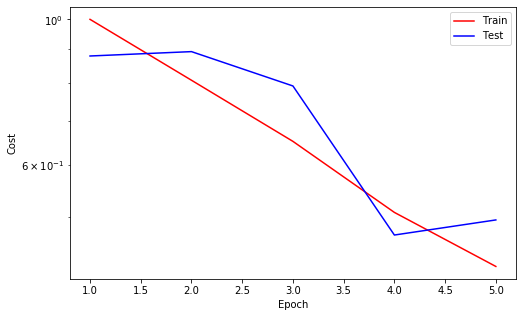

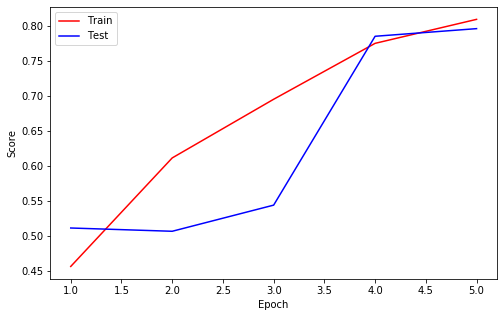

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3765 | Test_cost  = 0.3942 | Train_score = 0.8327 | Test_score = 0.8287 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3069 | Test_cost  = 0.2759 | Train_score = 0.8731 | Test_score = 0.8676 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2630 | Test_cost  = 0.3119 | Train_score = 0.8918 | Test_score = 0.8621 |
==> EarlyStop patience =  1 | Best test_score: 0.8676


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2438 | Test_cost  = 0.2489 | Train_score = 0.9021 | Test_score = 0.8902 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:58<00:00,  5.32s/it]



Epoch    10
Train_cost  = 0.2207 | Test_cost  = 0.3011 | Train_score = 0.9106 | Test_score = 0.8668 |


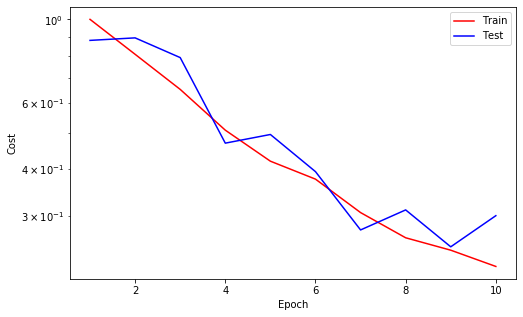

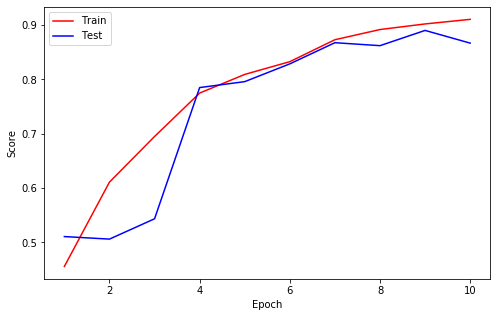

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.8902


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2078 | Test_cost  = 0.2757 | Train_score = 0.9100 | Test_score = 0.8956 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2030 | Test_cost  = 0.2470 | Train_score = 0.9195 | Test_score = 0.9065 |


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2115 | Test_cost  = 0.2406 | Train_score = 0.9090 | Test_score = 0.9065 |
==> EarlyStop patience =  1 | Best test_score: 0.9065


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2042 | Test_cost  = 0.1766 | Train_score = 0.9208 | Test_score = 0.9299 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [00:59<00:00,  5.39s/it]



Epoch    15
Train_cost  = 0.1705 | Test_cost  = 0.2304 | Train_score = 0.9354 | Test_score = 0.9151 |


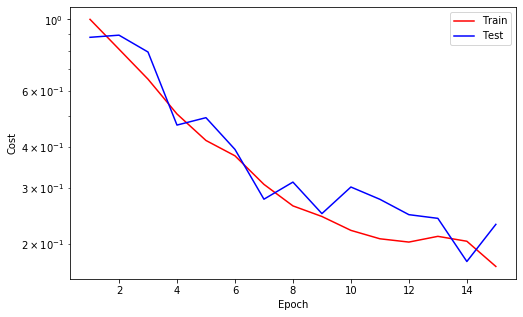

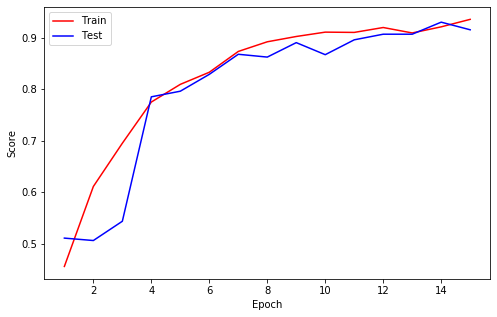

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1548 | Test_cost  = 0.1936 | Train_score = 0.9367 | Test_score = 0.9245 |
==> EarlyStop patience =  2 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1435 | Test_cost  = 0.2015 | Train_score = 0.9420 | Test_score = 0.9198 |
==> EarlyStop patience =  3 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1423 | Test_cost  = 0.2125 | Train_score = 0.9417 | Test_score = 0.9104 |
==> EarlyStop patience =  4 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1398 | Test_cost  = 0.1962 | Train_score = 0.9438 | Test_score = 0.9245 |
==> EarlyStop patience =  5 | Best test_score: 0.9299


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:35<00:00,  8.68s/it]



Epoch    20
Train_cost  = 0.1425 | Test_cost  = 0.2162 | Train_score = 0.9454 | Test_score = 0.9213 |


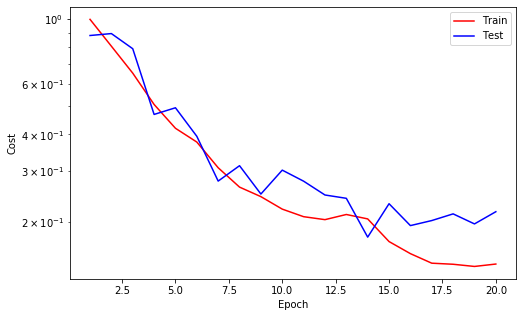

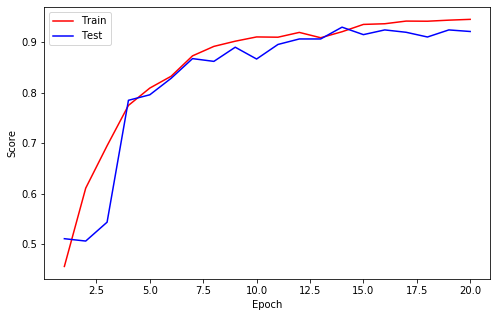

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  6 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1222 | Test_cost  = 0.2565 | Train_score = 0.9520 | Test_score = 0.9065 |
==> EarlyStop patience =  7 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1501 | Test_cost  = 0.2284 | Train_score = 0.9401 | Test_score = 0.9097 |
==> EarlyStop patience =  8 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1074 | Test_cost  = 0.1874 | Train_score = 0.9573 | Test_score = 0.9268 |
==> EarlyStop patience =  9 | Best test_score: 0.9299


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1171 | Test_cost  = 0.1823 | Train_score = 0.9520 | Test_score = 0.9408 |


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:04<00:00,  5.89s/it]



Epoch    25
Train_cost  = 0.1013 | Test_cost  = 0.2394 | Train_score = 0.9625 | Test_score = 0.9182 |


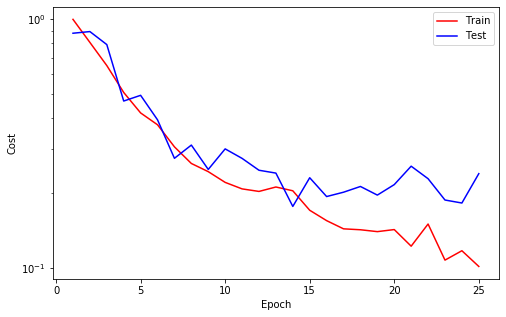

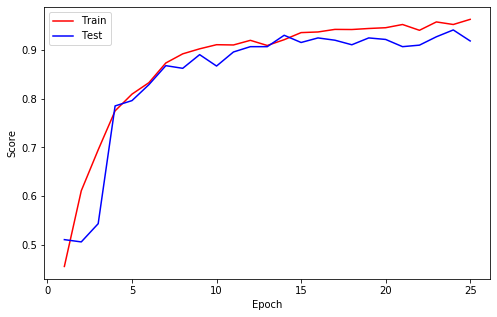

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  1 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1106 | Test_cost  = 0.1873 | Train_score = 0.9559 | Test_score = 0.9276 |
==> EarlyStop patience =  2 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0864 | Test_cost  = 0.2949 | Train_score = 0.9662 | Test_score = 0.9198 |
==> EarlyStop patience =  3 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1066 | Test_cost  = 0.2006 | Train_score = 0.9599 | Test_score = 0.9322 |
==> EarlyStop patience =  4 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0895 | Test_cost  = 0.3116 | Train_score = 0.9660 | Test_score = 0.9237 |
==> EarlyStop patience =  5 | Best test_score: 0.9408


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.74s/it]



Epoch    30
Train_cost  = 0.0975 | Test_cost  = 0.2068 | Train_score = 0.9644 | Test_score = 0.9260 |


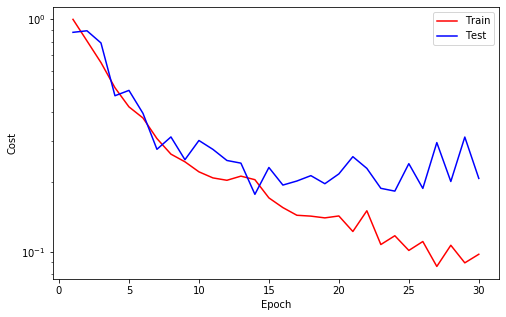

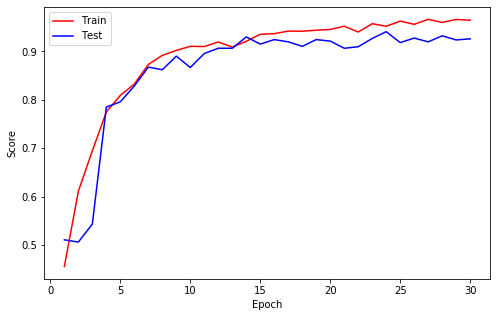

Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

==> EarlyStop patience =  6 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0955 | Test_cost  = 0.2862 | Train_score = 0.9602 | Test_score = 0.8980 |
==> EarlyStop patience =  7 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0954 | Test_cost  = 0.3326 | Train_score = 0.9639 | Test_score = 0.9120 |
==> EarlyStop patience =  8 | Best test_score: 0.9408


Train:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0848 | Test_cost  = 0.2164 | Train_score = 0.9670 | Test_score = 0.9361 |
==> EarlyStop patience =  9 | Best test_score: 0.9408


Test: 100%|████████████████████████████████████████████████████████████████████████████| 11/11 [01:07<00:00,  6.17s/it]



Epoch    34
Train_cost  = 0.0696 | Test_cost  = 0.2544 | Train_score = 0.9755 | Test_score = 0.9369 |
==> EarlyStop patience = 10 | Best test_score: 0.9408
==> Execute Early Stopping at epoch: 34 | Best test_score: 0.9408
==> Best model is saved at model-CNN/model-covid/model-covid-multiclass/model-tunning-2/


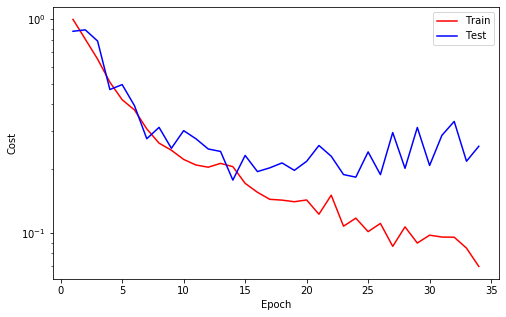

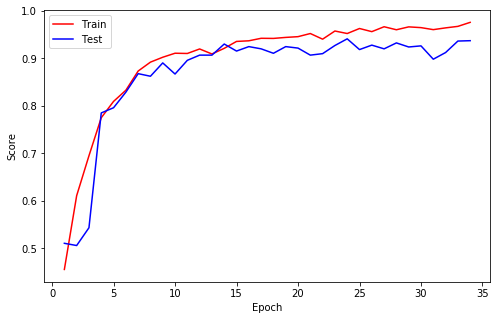

In [9]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Evaluation Model

### Accuracy and Cost

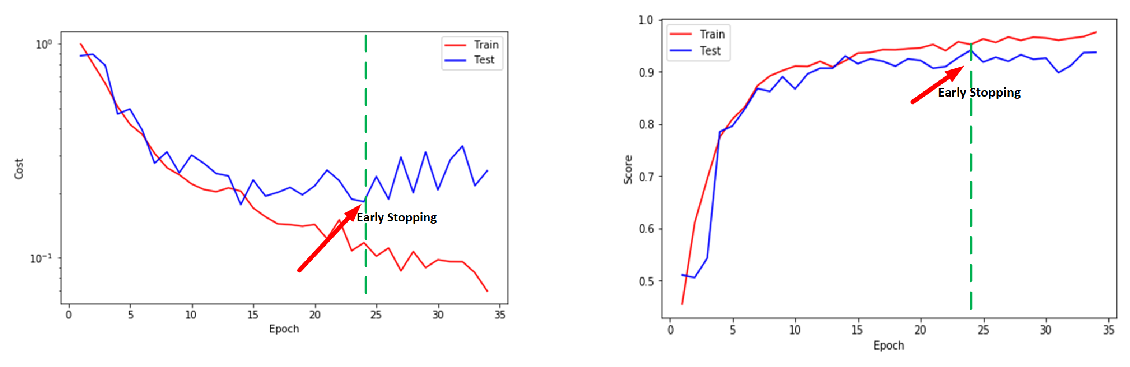

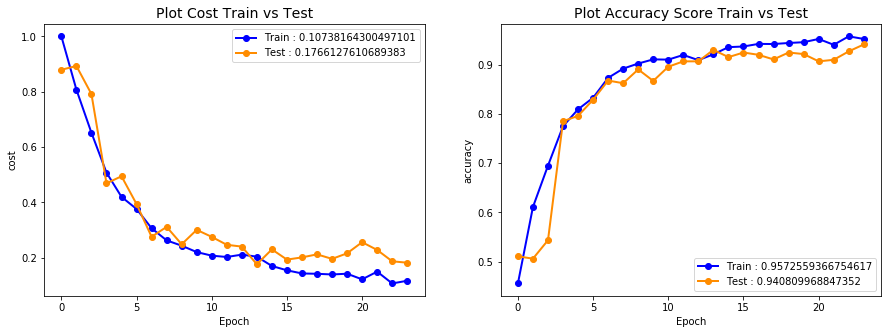

In [4]:
df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
df;

plt.figure(figsize=(20,10))
plt.subplot(121)
train_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/early_stop_cost.png')
plt.imshow(train_cm)
plt.axis('off');

plt.subplot(122)
test_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/early_stop_score.png')
plt.imshow(test_cm) 
plt.axis('off');


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Plot Cost Train vs Test", fontsize=14)
plt.plot(df.train_cost, 'bo-',linewidth=2, label=f"Train : {df.train_cost.min()}")
plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label=f"Test : {df.test_cost.min()}")
plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
plt.plot(df.train_score, 'bo-',linewidth=2, label=f"Train : {df.train_score.max()}")
plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label=f"Test : {df.test_score.max()}")
plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

### Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('Actual Labels', fontsize=18)
    plt.xlabel('Predicted Labels',fontsize=18)
    
    
# Graphical analytics
def predictionsplot_train(model, device, trainloader):
        model.train(False)
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
actuals, predictions = predictionsplot_train(model, device, trainloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Training', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("model/model-covid/model-covid-multiclass/model-tunning-2/plot_cm_train.png")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "model/model-covid/model-covid-multiclass/model-tunning-2/report_train.pth" )
print(report)

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# train_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(train_report,"model-CNN/model-covid/model-covid-multiclass/train_report.pth")

    
# Graphical analytics
def predictionsplot_test(model, device, testloader):
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = predictionsplot_test(model, device, testloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Testing', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("model/model-covid/model-covid-multiclass/model-tunning-2/plot_cm_test.png")

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# test_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(test_report,"model-CNN/model-covid/model-covid-multiclass/test_report.pth")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "model/model-covid/model-covid-multiclass/model-tunning-2/report_test.pth" )
print(report)

 << Traning Report >> 

              precision    recall  f1-score   support

    Covid-19       0.96      0.98      0.97      1235
      Normal       0.95      0.95      0.95      1255
   Pneumonia       0.98      0.97      0.97      1300

    accuracy                           0.96      3790
   macro avg       0.96      0.96      0.96      3790
weighted avg       0.96      0.96      0.96      3790

 

 << Testing Report >> 

              precision    recall  f1-score   support

    Covid-19       0.93      0.94      0.94       427
      Normal       0.93      0.93      0.93       431
   Pneumonia       0.96      0.96      0.96       426

    accuracy                           0.94      1284
   macro avg       0.94      0.94      0.94      1284
weighted avg       0.94      0.94      0.94      1284



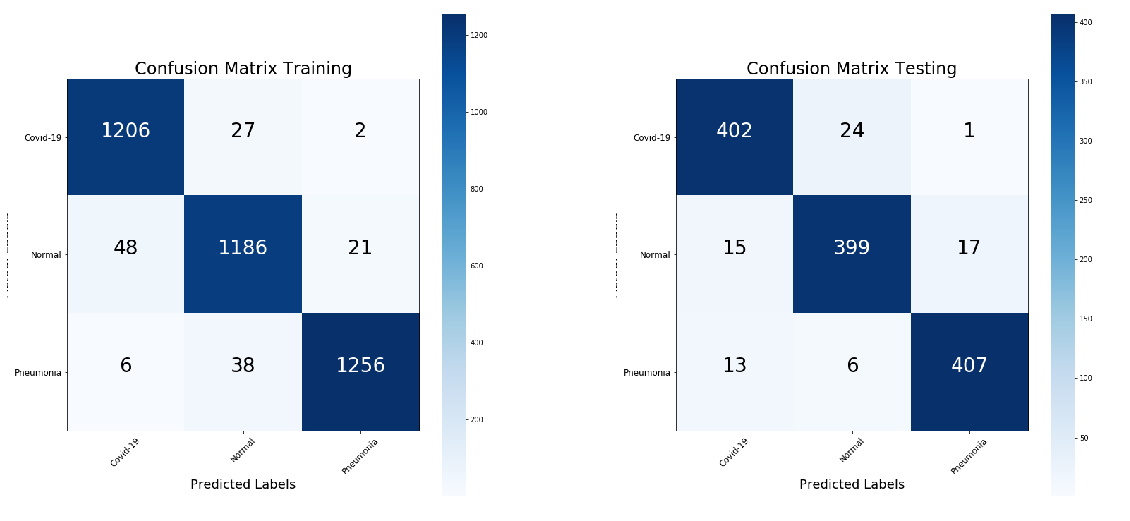

In [14]:
print(" << Traning Report >> \n")
print(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/report_train.pth"))

print(" \n\n << Testing Report >> \n")
print(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/report_test.pth"))

plt.figure(figsize=(20,25))
plt.subplot(121)
train_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/plot_cm_train.png')
plt.imshow(train_cm)
plt.axis('off');

plt.subplot(122)
test_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/plot_cm_test.png')
plt.imshow(test_cm) 
plt.axis('off');

### ROC Plot

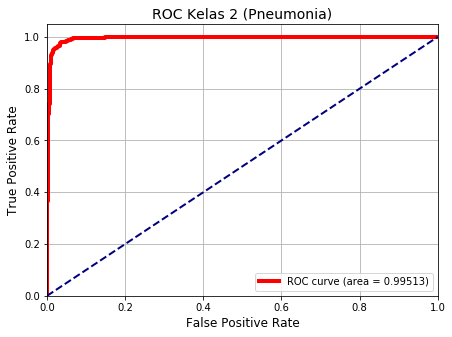

In [88]:
def test_class_probabilities(model, device, testloader, which_class):
    model.eval()
    actuals_test = []
    probabilities = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_test.extend(labels.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals_test], [i.item() for i in probabilities]

which_class = 2 #[0,1,2] >> kelas yang mana??
actuals_test, class_probabilities = test_class_probabilities(model, device, testloader, which_class)

fpr_test, tpr_test, _ = roc_curve(actuals_test, class_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))

plt.plot(fpr_test, tpr_test, color='red',lw=4, label='ROC curve (area = %0.5f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Kelas 2 (Pneumonia)', fontsize=14)
plt.legend(loc="lower right")
plt.grid('on')

plt.savefig("model/model-covid/model-covid-multiclass/model-tunning-2/plot/roc_class_2.png")
plt.show()

## Load Model

In [8]:
weights = torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/model/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device);

In [9]:
torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/configs.pth")

Config(author=Ridho Alhafizhi, batch_norm=False, batch_size=128, conv1=8, conv2=16, conv3=32, conv4=64, crop_size=224, dropout=0.15, in_channel=1, in_size=12544, kernel=5, n1=512, n2=256, out_channel=256, out_size=3, pad=2)

In [13]:
df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
df;

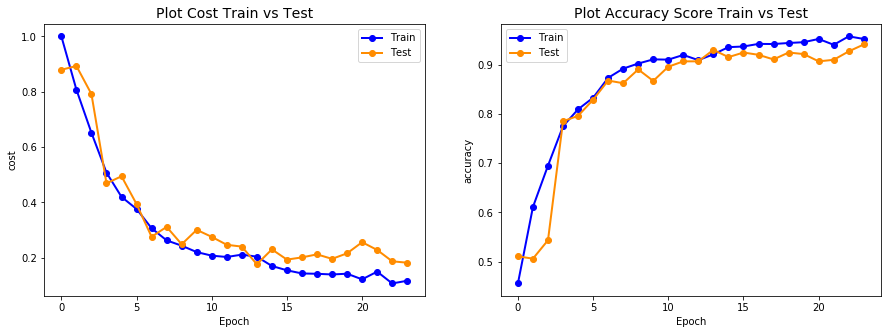

In [14]:
df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
df;

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Plot Cost Train vs Test", fontsize=14)
plt.plot(df.train_cost, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
plt.plot(df.train_score, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

# plt.savefig("model/model-covid/model-covid-multiclass/model-tunning-2/plot_score_cost_earlystop.png")

## Prediction

In [78]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [79]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2,
        0, 0, 0, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 1,
        0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 2, 1, 0, 1, 1,
        1, 2, 2, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 2, 0, 2, 2, 1, 1, 0, 1, 1,
        2, 0, 2, 1, 1, 1, 1, 2])

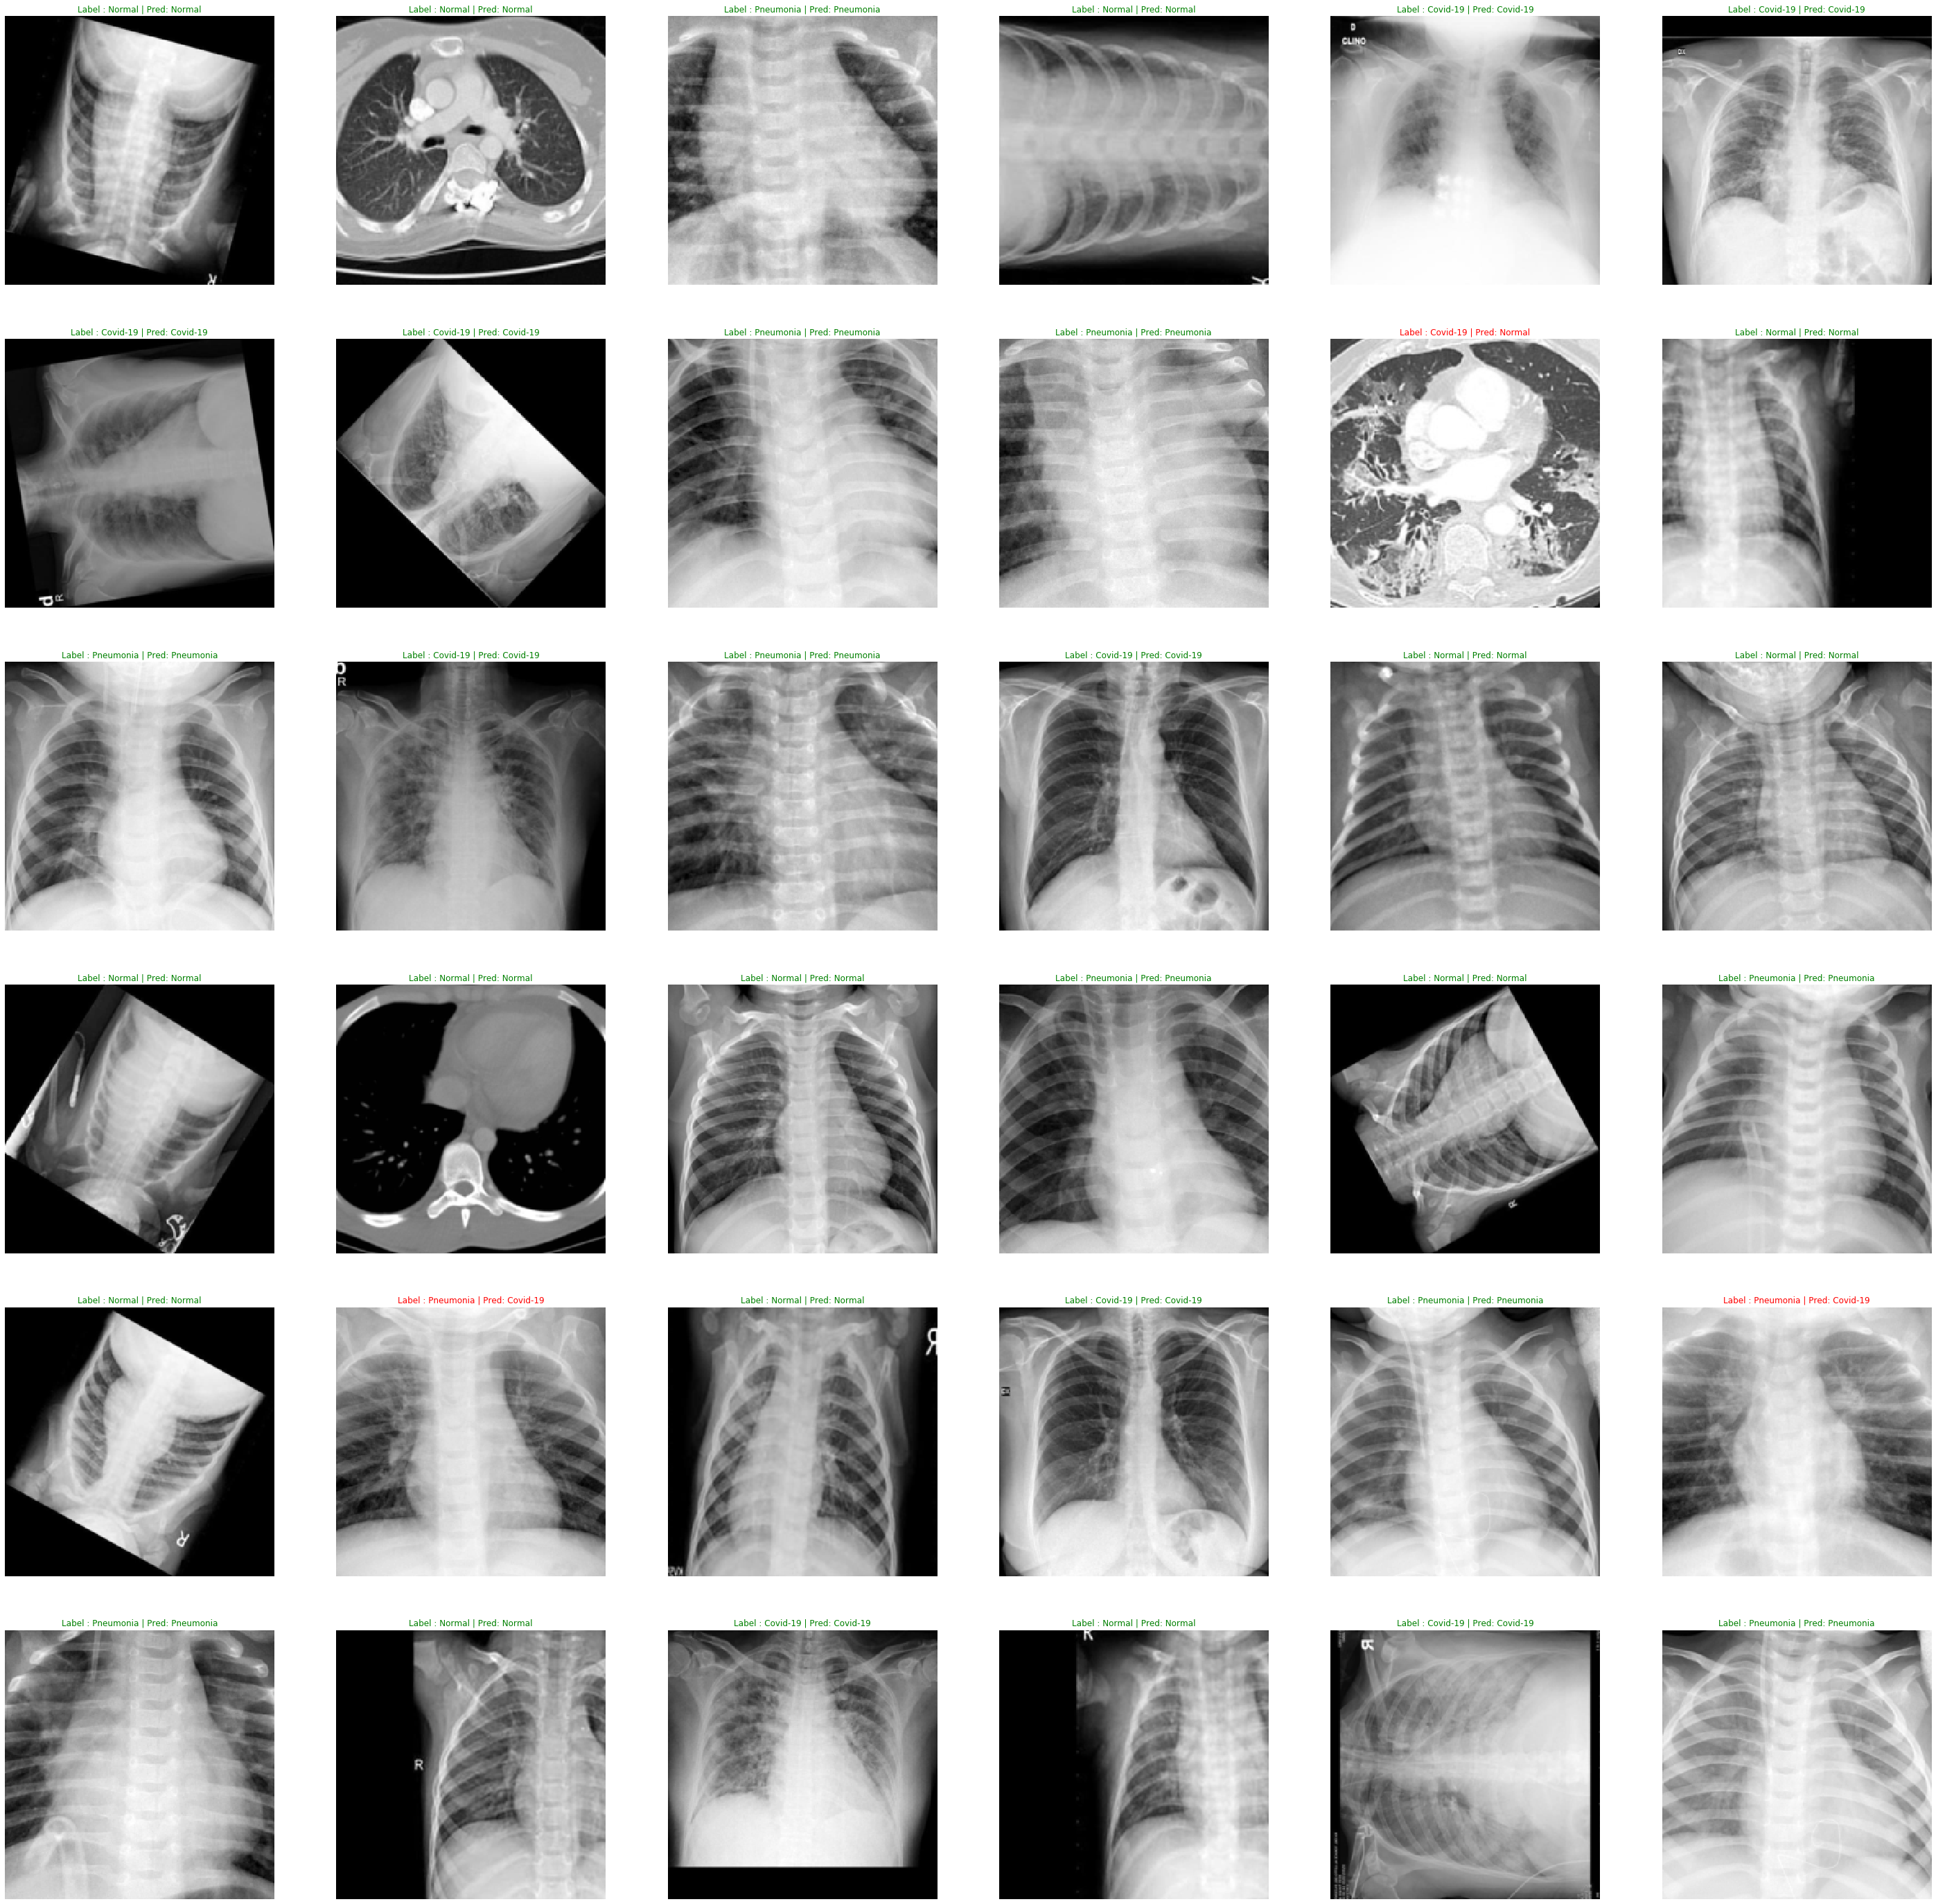

In [80]:
fig, axes = plt.subplots(6,6, figsize=(50, 50))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {"color" : "g"} if label == pred else {"color":"r"}
    
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
    font = {"color" : "g"} if label == pred else {"color":"r"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred: {pred}", fontdict=font)
    ax.axis("off");
# plt.savefig("model-CNN/model-covid/model-covid-multiclass/model-tunning-2/prediction.png")